# Country Comparisons

## Comparing emissions aggregated by country across various sources

Currently supports trace 2023, trace 2022, and IEA methane from 2023. Finds the difference and percent change

In [1]:
import pandas as pd
import numpy as np

# plotting not yet supported
from cartopy import crs as ccrs, feature as cfeature 
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

In [114]:
import pycountry    # finding country names
import difflib      # quanitfying string differences

## Loading Data

In [115]:
volumes = pd.read_csv("./data/country_percent_scale_080124.csv")    # read in volumes of production in 2023

In [116]:
# load in all the trace and iea data and sort for only relevant columns


trace23_prod = pd.read_csv("./data/trace23_prod2-1.csv")               # production values
trace23_prod = trace23_prod.rename(columns={
    'CO2_emissions_tonnes': 'CO2_trace23',
    'CH4_emissions_tonnes': 'CH4_trace23'
})
trace23_trans = pd.read_csv("./data/trace23_trans2-1.csv")             # transportation values
trace23_trans = trace23_trans.rename(columns={
    'CO2_emissions_tonnes': 'CO2_trace23',
    'CH4_emissions_tonnes': 'CH4_trace23'
})
trace22_in = pd.read_csv("./data/trace22.csv")                      # production and transportation included
iea_in = pd.read_csv("./data/iea.csv")                              # production only
iea_co2_in = pd.read_csv("./data/iea_co2.csv")
# eia_22 = pd.read_csv("")

## Useful Functions

In [117]:
# Function to get the closest ISO3 code from a country name
def get_closest_iso3_code(country_name):

    if isinstance(country_name, str):

        country_names = [country.name for country in pycountry.countries]                       # gets all possible country names
        closest_match = difflib.get_close_matches(country_name, country_names, n=1, cutoff=0.9) # finds the closest match that matches ninety pct

        if closest_match:
            country = pycountry.countries.get(name=closest_match[0])
            return country.alpha_3                                                              # return the closest match's iso code
        
    return None

In [118]:
# Function to create new columns for difference, percent change, and percentage makeup
def add_difference_and_percent(df, col1, col2):
    # Calculate the difference
    diff_col_name = f'{col1}_minus_{col2}'
    df[diff_col_name] = df[col1] - df[col2]
    
    # Calculate the percent change
    pct_change_col_name = f'{col1}_pct_change_{col2}'
    df[pct_change_col_name] = (df[col1] - df[col2]) / df[col2] * 100

    # Calculate the percent of previous
    # pct_prev_col_name = f'{col1}_pct_previous_{col2}'
    # df[pct_prev_col_name] = df[col1] / df[col2] * 100
    
    return df

## Preprocessing

In [119]:
# OPGEEv4 run of recent data


keep = ['iso3_country','CO2_trace23', 'CH4_trace23']                                        # column names to maintain

trace23 = trace23_prod[keep].merge(                                                         # merging production and transportation
    trace23_trans[keep],                                                                    # only for the columns that are relevant
    on='iso3_country',                                                                      # adding suffixes to specify production
    suffixes=["_prod","_trans"]                                                             # or transportation
)
trace23['CO2_trace23_total'] = trace23['CO2_trace23_prod'] + trace23['CO2_trace23_trans']   # creating columns for totals of each gas
trace23['CH4_trace23_total'] = trace23['CH4_trace23_prod'] + trace23['CH4_trace23_trans']   # by summing production and transportation
# trace23

In [120]:
# country aggregated former run


trace22 = trace22_in[['iso3_country','end_time','gas','emissions_quantity']]            # restrict to only relevant columns
trace22 = trace22[trace22['end_time'].str.contains('2022')].drop(columns=['end_time'])  # keep only items that are from 2022 run and drop time
trace22 = trace22[trace22['gas'].isin(['co2','ch4'])]                                   # restrict to only carbon dioxide and methane

# pivot table and reset index to mimic other format
trace22 = trace22.pivot(                                                                
    index='iso3_country', columns='gas', values='emissions_quantity'
).reset_index()

# give column names for the gases
trace22.columns.name = None                                                         
trace22 = trace22.rename(columns={
    'co2': 'CO2_trace22_total',
    'ch4': 'CH4_trace22_total'
})

trace22 = trace22.replace(0,np.nan)                                                     # convert zeros to nans for consistency
# trace22

In [121]:
# handling IEA info


# applying iso code finding function to convert country names to iso codes
iea_in['iso3_country'] = iea_in['country'].apply(get_closest_iso3_code)

iea_23 = iea_in[iea_in['baseYear']=='2023']                                     # only from past year

# selecting emissions only for parts from production
iea_23 = iea_23[iea_23['segment'].isin(['Offshore gas',                         
                                        'Offshore oil',
                                        'Onshore gas',
                                        'Onshore oil'])]


iea_sum = iea_23.groupby('iso3_country')['emissions (kt)'].sum().reset_index()  # sum across production
iea_sum['CH4_iea_prod'] = iea_sum['emissions (kt)'] * 1000                      # convert kt to tons
# iea_sum

In [122]:
# handling IEA carbon dioxide info

# iea_co2_in = iea_co2_in.replace(' -   ', 0)
iea_co2 = iea_co2_in[iea_co2_in['base_year']=='2021']                              # avoiding duplicates 

iea_co2 = iea_co2[['iso3_country',' IEA CO2 emissions_kt ', ' IEA CO2 emissions_kt + VIIRS flaring ']]

iea_co2['IEA co2'] = iea_co2[' IEA CO2 emissions_kt '].astype(float) * 1000
iea_co2['IEA co2 + VIIRS'] = iea_co2[' IEA CO2 emissions_kt + VIIRS flaring '].astype(float) * 1000

iea_co2

,iso3_country,IEA CO2 emissions_kt,IEA CO2 emissions_kt + VIIRS flaring,IEA co2,IEA co2 + VIIRS
0,DZA,66.00,14280.00,66000.0,14280000.0
1,AGO,NaN,2874.00,NaN,2874000.0
2,ARG,9509.00,11543.00,9509000.0,11543000.0
3,AUS,3418.00,4211.00,3418000.0,4211000.0
4,AZE,129.00,478.00,129000.0,478000.0
...,...,...,...,...,...
96,URY,NaN,NaN,NaN,NaN
97,UZB,402.00,1176.00,402000.0,1176000.0
98,VEN,11296.00,26506.00,11296000.0,26506000.0
99,VNM,NaN,1043.00,NaN,1043000.0


In [123]:
# combining all datasets


# set indexes to country codes to make joining easy
volumes.set_index('iso3_country', inplace=True)
trace23.set_index('iso3_country', inplace=True)
trace22.set_index('iso3_country', inplace=True)
iea_sum.set_index('iso3_country', inplace=True)
iea_co2.set_index('iso3_country', inplace=True)

# Join dataframes
joined = volumes.join(
    trace23, how='outer').join(
        trace22, how='outer').join(
            iea_sum[['CH4_iea_prod']], how='outer').join(
                iea_co2[['IEA co2', 'IEA co2 + VIIRS']], how='outer'
            )

# Reset index to make 'iso3_country' a column again
joined.reset_index(inplace=True)


## Create new columns

In [128]:
merged = joined                                                                     # to preserve joined as a table without calculated columns

merged = add_difference_and_percent(merged,'CH4_trace23_prod','CH4_iea_prod')       # adding columns for production diff from iea
merged = add_difference_and_percent(merged,'CH4_trace23_total','CH4_trace22_total') # adding columns for total methane difference for trace
merged = add_difference_and_percent(merged,'CO2_trace23_total','CO2_trace22_total') # adding columns for total carbon dioxide diff for trace
merged = add_difference_and_percent(merged,'CO2_trace23_prod','IEA co2')            # adding columns for carbon dioxide from IEA
merged = add_difference_and_percent(merged,'CO2_trace23_prod','IEA co2 + VIIRS')    # adding columns for TOTAL carbon dioxide from IEA

In [129]:
merged = merged.dropna(subset=merged.columns[1:], how='all')    # remove countries with no data
merged.reset_index(drop=True,inplace=True)
# merged

In [130]:
merged.to_csv('./data/more_countrycomps.csv',index=False) # write csv of this

: 

## Mapping
Below is the beginning of some mapping code for these comparisons but it is not yet supported

KeyError: 'Value'

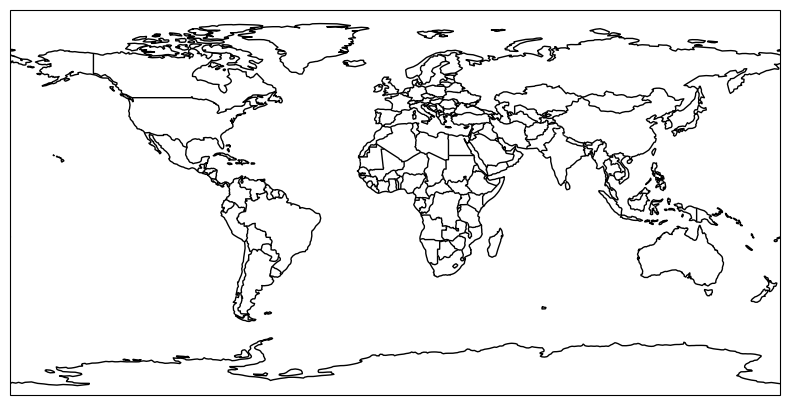

In [127]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# Define the countries you want to highlight
highlight_countries = ['United States of America', 'Canada', 'Mexico']

# Create a map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

# Normalize the values for color mapping
norm = plt.Normalize(merged['Value'].min(), merged['Value'].max())
cmap = plt.cm.viridis

# Highlight countries based on the 'Value' column
for country in merged['Country']:
    country_name = country.attributes['NAME']
    if country_name in merged['Country'].values:
        value = merged[merged['Country'] == country_name]['Value'].values[0]
        color = cmap(norm(value))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=color, edgecolor='black')
    else:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgray', edgecolor='black')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='horizontal', label='Value')

# Add title and show plot
plt.title('Highlighted Countries by Value')
plt.show()
